Product Owner have to choose between two KPIs of his product and invest money in one of possible directions. For example - traffic attraction or conversion optimization. These are two strategies and his backlog have to be prioritized right now. Here we use ML scores as a measure of KPI selection. In fact we look how this or that KPI helps to predict possible cash flow. In this example we have one product with fixed price. We use web metrics to understand what strategy should be chosen - attraction or activation, ads  or CRO. I show that standard statistical measures like correlation fail and nonlinear ML models give insight. It works on relatively small data (1092 records) - natural limitation. That's why ensemble voting, binning of target and dimension reduction are involved to avoid overfit. I explore two groups of metrics. First (I) corresponds to conversion - bounce rate, depth of view, conversion to contact page, time of session. Second (II) corresponds to traffic (ads channel is a major factor for this product): number of sessions, number uniqie new visitors, number of views. I use the daily discretization of web and crm data. The target function is a number of commercial offers/day. Input features correspond to the New Visitors segment (!). Segmentation is done, using Google Analytics API. 

In [120]:
from __future__ import division
import warnings
warnings.filterwarnings("ignore")

Define general parameters

In [121]:
split_num=10 #number of cross validation intervals
out_sample=0.5 #out-of-sample split
neigbors_maximum=10 #max number of neighbors for KNN
boundary=0.5 #boundary for Offers classification

Import general libraries: arrays,dateframe

In [122]:
import numpy as np #work with arrays
import pandas as pd #work with dateframe
from pandas import set_option
import matplotlib.pyplot as plt #work with charts
import seaborn as sns #work with color charts
from pylab import plot, ylim, xlim, show, xlabel, ylabel, grid #work with charts
from numpy import linspace, loadtxt, ones, convolve

Import statistical libraries

In [123]:
from scipy.stats.stats import pearsonr #correlation method
from statistics import median #median search

Import ML libraries for out-of-sample tests and hyperparameter tuning

In [124]:
from sklearn.model_selection import train_test_split #standard out-of-sample test
from sklearn.model_selection import cross_val_score #cross validation test
from sklearn.model_selection import GridSearchCV #hyperperameter tuning
from sklearn.model_selection import KFold #sample split

Import ML libraries

In [125]:
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from mlxtend.regressor import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import ExtraTreesClassifier

In [126]:
def standart(x):
    max_value=x.max();
    min_value=x.min()
    z=(x-min_value) / (max_value - min_value)
    return z

Custom functions - correlation map

In [127]:
def cormap(x):
  corr=x.corr();fig=plt.figure(figsize=(10, 7))
  g=sns.heatmap(corr,annot=True,linewidths=.2, cbar_kws={"orientation": "horizontal"})
  plt.show()

Custom functions - Person coefficient output

In [128]:
def cf(x,y):
  CFV=pearsonr(x,y);correlation=str(abs(round(int(100*CFV[0]))))
  p_mystake=str(round((100*CFV[1]),3));cf_mst=[correlation,p_mystake]
  return cf_mst

Custom functions - exploratory analysis

In [129]:
def eda(x):
  pd.plotting.scatter_matrix(x,figsize=[8,8],diagonal='kde',grid=True,ax=None,range_padding=1)
  plt.show()

Classification of continuous var by median

In [130]:
def get_class(x):
  #threshold=median(list(x))
  threshold=boundary
  class_type=[]
  for item in list(x):
    if item>=threshold: label=1;class_type.append(label)
    if item<threshold: label=0;class_type.append(label)
  return class_type  

Custom functions - plot PCA components and moving average

In [131]:
def pca(x,y):
  pca=PCA()
  pca.fit(y) 
  PCA(copy=True)
  features=x
  pca.explained_variance_=standart(pca.explained_variance_)
  pca.explained_variance_=list(np.array(pca.explained_variance_)*100)
  plt.bar(x, pca.explained_variance_,width=0.5)
  plt.xticks(features);plt.ylabel('variance');plt.xlabel('PCA feature')
  print('Input of component - PCA:')
  for i in range(0,len(pca.explained_variance_)):
    print(str(x[i])+': '+str(int(pca.explained_variance_[i]))+'%')
    i=i+1
  plt.show()

def movingaverage(interval, window_size):
    window= np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

Read data from xls file. 3 years of daily records.

In [132]:
path='web_crm.xlsx'
df=pd.read_excel(path)

Show column names

In [133]:
column_names=list(df.columns.values)
print('All fields:',column_names)

All fields: ['Date', 'Visits', 'Viewers', 'Views', 'BR', 'Depth', 'Time', 'Offers']


Show time interval:

In [134]:
print('Data Start:',list(df['Date'])[0])
print('Data End:',list(df['Date'])[-1])

Data Start: 2016-05-09
Data End: 2019-05-07


Show number of records - small data

In [135]:
print('Number of records:', len(df))

Number of records: 1092


Let's remove weekends

In [136]:
df['Date']=pd.to_datetime(df['Date'], format="%Y/%m/%d")
df['Day of week']=df['Date'].dt.day_name()
indexNames=df[df['Day of week']=='Saturday'].index
df.drop(indexNames,inplace=True)
indexNames=df[df['Day of week']=='Sunday'].index
df.drop(indexNames,inplace=True)
del df['Day of week']
df_origin=df.copy()

Compres features to (0,1) to avoid ML unstability

In [137]:
df['Visits']=standart(df['Visits'])
df['Viewers']=standart(df['Viewers'])
df['Views']=standart(df['Views'])
df['BR']=standart(df['BR'])
df['Depth']=standart(df['Depth'])
df['Time']=standart(df['Time'])
df['Offers']=standart(df['Offers'])

Remove date feature

In [138]:
del df['Date']

Make correlation map

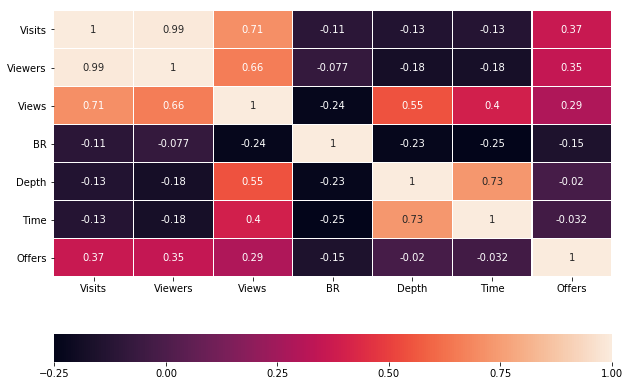

In [139]:
cormap(df)

Actually no interesting information according to linear approach

Let's validate this by EDA visualization chart

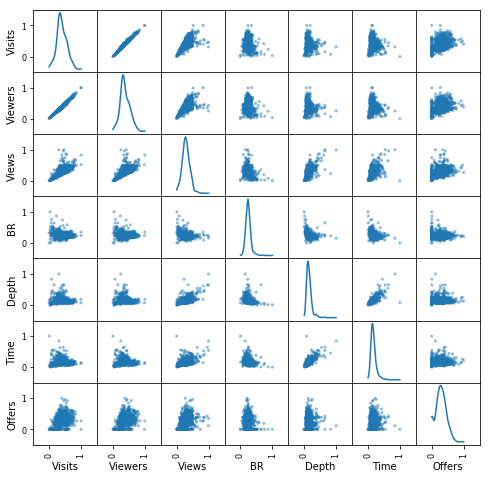

In [140]:
eda(df)

Not brilliant regression however for Offers - botoom left field. However we notice that visits and viewers have good correlation and regression. Ok, let's analyze feature input by PCA.

Input of component - PCA:
Visits: 100%
Viewers: 36%
Views: 34%
BR: 10%
Depth: 4%
Time: 0%
Offers: 0%


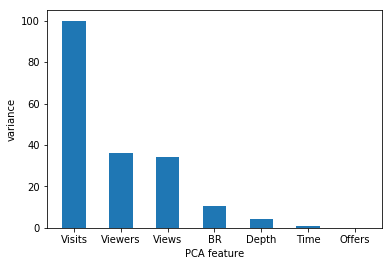

In [141]:
column_names=df.columns
pca(column_names,df)

Number of sessions is in top. Other metrcis have less significance and are naturally ordered. We get EDA for Offers distribution. 

Offers:
count    782.000
mean       0.288
std        0.174
min        0.000
25%        0.192
50%        0.269
75%        0.385
max        1.000
Name: Offers, dtype: float64


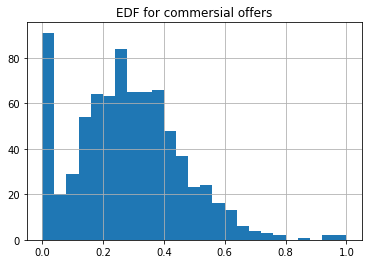

In [142]:
set_option('display.width',100)
set_option('precision',3)

print('Offers:')
description=df['Offers'].describe()
print(description)

df['Offers'].hist(bins=25)
plt.title('EDF for commersial offers')
plt.show()

It's noteble that zero conversion spoils regression. Except this variant it looks like normal. So, we may split it by average+standard into 2 classes by 0.5 threshold. Let's detect percent of positive offers per day first.

In [143]:
offers_positive=len(df[df['Offers']>0])
general_length=len(df)
print('Number of days with [offers>0] number is '+str(round(100*offers_positive/general_length))+'%')

Number of days with [offers>0] number is 89%


In [144]:
df_binary=df.copy()
df_binary['Offers binary']=get_class(df_binary['Offers'])

Let's split 5 features from target.

In [145]:
array_df_binary=df_binary.values
X=array_df_binary[:,0:6];Y=array_df_binary[:,7]

Estimation of feature importance based on tree classifier. 

In [146]:
model=ExtraTreesClassifier(n_estimators=100)
model.fit(X, Y)
print('Importance of Visits,Viewers,Views,BR,Depth,Time:',model.feature_importances_)

Importance of Visits,Viewers,Views,BR,Depth,Time: [0.17268628 0.1757548  0.16831854 0.16540102 0.15110635 0.16673301]


We can see that both conversion and traffic metrics influences the target by the result corresponds to PCA in the qualitative way. Construct arrays for fetures and target

In [147]:
array_reg=df.values
X_reg=array_reg[:,0:6];Y_reg=array_reg[:,6]

Try regression models. Let's do ensemble prediction by stacking technique 

In [148]:
kfold=KFold(n_splits=split_num, random_state=7)
ridge=Ridge(alpha=1,fit_intercept=True)
knn=KNeighborsRegressor()
svr=SVR(gamma='auto')

stregr=StackingRegressor(regressors=[ridge,knn,svr], meta_regressor=ridge)
results=cross_val_score(stregr, X_reg, Y_reg, cv=kfold, scoring='r2')
print('Mean R2 for stacking Regression:',round(results.mean(),2))
print('Deviation for stacking Regression:',round(results.std(),2))

Mean R2 for stacking Regression: 0.04
Deviation for stacking Regression: 0.14


OK. Regression gives poor results - it's not surprise for small data. Let's move to classifiers with binned target. Let's make an ensemble of classificators for binary table.

In [149]:
estimators = []
a=KNeighborsClassifier(n_neighbors=neigbors_maximum)
b=GaussianNB()
c=DecisionTreeClassifier(criterion='entropy')

estimators.append(('knn',a))
estimators.append(('naive', b))
estimators.append(('dt', c))

ensemble = VotingClassifier(estimators)
results = cross_val_score(ensemble, X, Y, cv=kfold)
print('Average score of validation for ensamble:'+str(round(100*results.mean()))+'%')
print('Deviation of validation score:'+str(round(100*results.std()))+'%')

X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=out_sample)
model=ensemble;model.fit(X_train,Y_train)
score_nb=model.score(X_test, Y_test)
print('Accuracy for the out-of-sample 50/50 test='+str(100*round((score_nb),1))+'%')

Average score of validation for ensamble:86.0%
Deviation of validation score:6.0%
Accuracy for the out-of-sample 50/50 test=90.0%


Great! What if we remove consequently remove features according to PCA/TreeClassificator results. We look at the accuracy. We remove features untill it start decreasing. Finally we stop at one feature and the accuracy is rised due to dimension reduction. 

In [150]:
X=array_df_binary[:,0:1]
estimators = []
a=KNeighborsClassifier(n_neighbors=neigbors_maximum)
b=GaussianNB()
c=DecisionTreeClassifier(criterion='entropy')

estimators.append(('knn',a))
estimators.append(('naive', b))
estimators.append(('dt', c))

ensemble = VotingClassifier(estimators)
results = cross_val_score(ensemble, X, Y, cv=kfold)
print('Average score of validation for ensamble:'+str(round(100*results.mean()))+'%')
print('Deviation of validation score:'+str(round(100*results.std()))+'%')

X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=out_sample)
model=ensemble;model.fit(X_train,Y_train)
score_nb=model.score(X_test, Y_test)
print('Accuracy for the out-of-sample 50/50 test='+str(100*round((score_nb),1))+'%')

Average score of validation for ensamble:88.0%
Deviation of validation score:6.0%
Accuracy for the out-of-sample 50/50 test=90.0%


Less features - less overfit risk. So, finally we have sessions as a most powerful metric, which predicts binary function of offers number with accuracy of 88%. However not accuracy, but factor analysis is essential. PCA, EDA, Tree Classifier show that traffic features determine conversion into the commercial offer. PO may focus on traffic attraction more than web CRO. Now let's try increase signal/noise relations for the feature and the target.   

Let's make a scatter plot of Sessions, Offers and delta using moving averages

<Figure size 432x288 with 0 Axes>

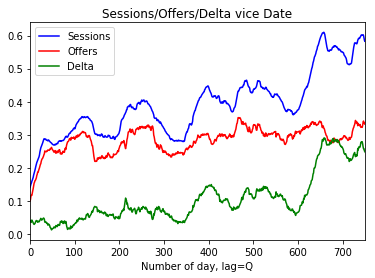

<Figure size 432x288 with 0 Axes>

In [151]:
df_origin['Visits']=standart(df_origin['Visits'])
df_origin['Offers']=standart(df_origin['Offers'])
Sessions=list(df_origin['Visits'])
Offers=list(df_origin['Offers'])
x=range(len(Sessions))

y_av_ses=list(movingaverage(Sessions,60))
y_av_offers=list(movingaverage(Offers,60))
delta=[(x-y) for x,y in zip(y_av_ses, y_av_offers)]

plt.plot(x, y_av_ses,"b")
plt.plot(x, y_av_offers,"r")
plt.plot(x, delta,"g")
plt.title('Sessions/Offers/Delta vice Date')
plt.xlabel('Number of day, lag=Q')
plt.gca().legend(('Sessions','Offers','Delta'))
plt.xlim(0,750)
plt.figure()

We can note that using moving average with quarter lag helps to notice relationship. 

In [152]:
d={'Sessions':y_av_ses,'Offers':y_av_offers,'Delta':delta}
df_movings=pd.DataFrame(d)
print(df_movings.corr())

          Sessions  Offers  Delta
Sessions     1.000   0.710  0.924
Offers       0.710   1.000  0.388
Delta        0.924   0.388  1.000


Here we see that noise reduction indeed helps to see the influence of traffic on conversion - the correlation between Sessions and Offers is >70%. However delta between movings also correlates with session. It gives insight that we have nonlinear case, which fits to ML application. That's why the ML techniques are valuable for web analytics and for the web/crm end-to-end analytics. 